In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Load Appian Stock Data

In [2]:
appn = pdr.get_data_yahoo('APPN','2019-05-31')
appn.drop('Adj Close', axis=1, inplace=True)
appn.head()

,High,Low,Open,Close,Volume
Date,,,,,
2019-05-31,36.520000,35.436001,35.520000,36.130001,331800
2019-06-03,36.570000,32.650002,36.000000,33.299999,677900
2019-06-04,34.560001,33.459999,33.919998,34.360001,507700
2019-06-05,34.790001,33.040001,34.540001,34.730000,445500
2019-06-06,34.480000,33.150002,34.060001,34.220001,326800


In [3]:
appn['3-day'] = appn['Close'].rolling(3).mean()
appn['9-day'] = appn['Close'].rolling(9).mean()
appn['21-day'] = appn['Close'].rolling(21).mean()
appn['Change'] = np.log(appn.Close / appn.Close.shift())
appn.tail()

,High,Low,Open,Close,Volume,3-day,9-day,21-day,Change
Date,,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,88.220001,84.880000,90.346190,0.023709
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,88.806669,85.348889,88.746190,-0.032576
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,90.676669,86.631111,87.721428,0.070423
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,90.986669,87.454445,87.013333,-0.027621
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,92.113335,88.414445,86.472857,-0.004935


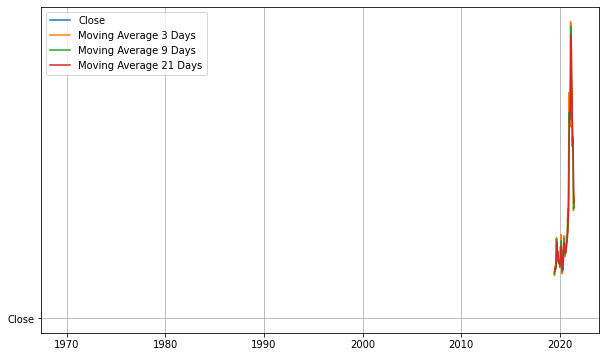

In [4]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(['Close'],label='Close')
plt.plot(appn['3-day'],label='Moving Average 3 Days')
plt.plot(appn['9-day'],label='Moving Average 9 Days')
plt.plot(appn['21-day'],label='Moving Average 21 Days')
plt.legend(loc=2)

## Zoom in the changing period

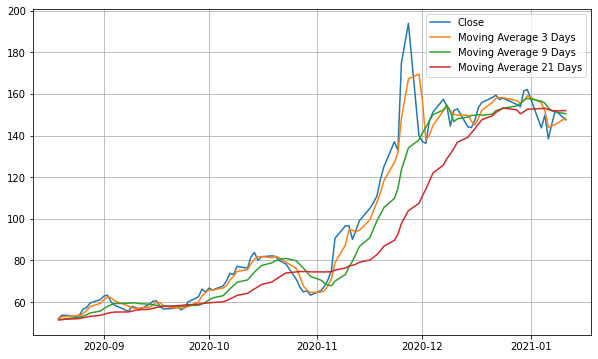

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['3-day'][-200:-100],label='Moving Average 3 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=1)

In [6]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-9-21'] = np.where(appn['9-day'] > appn['21-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-9-21'] = np.where(appn['9-day'] < appn['21-day'],-1,appn['position-9-21'])

<AxesSubplot:xlabel='Date'>

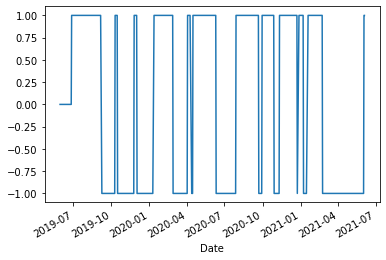

In [7]:
appn['position-9-21'].plot()

<AxesSubplot:xlabel='Date'>

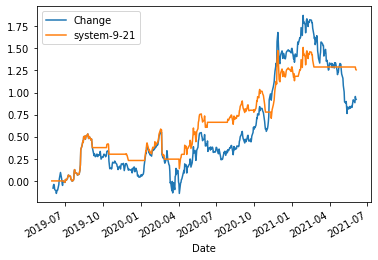

In [8]:
# Whether we are making money with this system
appn['system-9-21'] = np.where(appn['position-9-21'] > 0, appn['position-9-21']* appn['Change'],0)
appn[['Change','system-9-21']].cumsum().plot()

<AxesSubplot:xlabel='Date'>

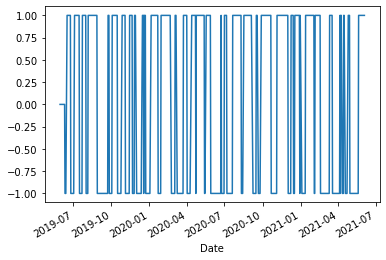

In [9]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-3-9'] = np.where(appn['3-day'] > appn['9-day'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-3-9'] = np.where(appn['3-day'] < appn['9-day'],-1,appn['position-3-9'])
appn['position-3-9'].plot()

<AxesSubplot:xlabel='Date'>

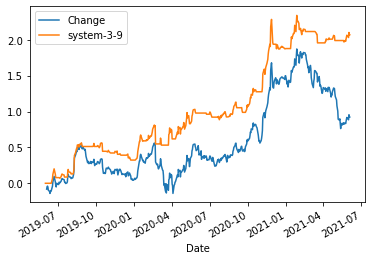

In [10]:
# Whether we are making money with this system
appn['system-3-9'] = np.where(appn['position-3-9'] > 0, appn['position-3-9']* appn['Change'],0)
appn[['Change','system-3-9']].cumsum().plot()

## Prepare data for DGIM processing

In [11]:
bit_depth = 16
appn_list = appn['Close'].tolist()
appn_3day_list = appn['3-day'].tolist()
appn_9day_list = appn['9-day'].tolist()
appn_21day_list = appn['21-day'].tolist()
appn_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in appn_list ]
print(appn_list[0],appn_list_bin[0], len(appn_list_bin))

36.130001068115234 [0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0] 508


## DGIM Moving Average Algorithms

In [12]:
import math
import copy

class DGIM:
    buckets = []
    times = {}
    bits = []
    value = 0
    num_buckets = 0
    
    def __init__(self, num_buckets, snapshot):
        self.buckets.clear()
        self.times.clear()
        self.bits.clear()
        for b in range(num_buckets):
            self.buckets.append(0)
        for d in range(bit_depth):
            self.bits.append(0)
        self.num_buckets = num_buckets
        s = copy.deepcopy(snapshot)
        s.reverse()
        for b in s:
            self.add_bit(b)
    
    def calc_value(self):
        v = 0
        for i in range(self.num_buckets):
            if i == self.num_buckets-1 and self.buckets[i] > 0:
                v += pow(2,i)*self.buckets[i]
                v -= pow(2,i)/2
            elif (self.buckets[i] > 0):
                v += pow(2,i)*self.buckets[i]
                if (self.buckets[i+1] == 0):
                    v -= pow(2,i)/2
        self.value = math.ceil(v)
        
    def add_bit(self,bit):
        
        self.bits.insert(0,bit);
        self.bits = self.bits[0:-1]
        
        if bit == 1:
            self.buckets[0] += 1
        for i in range(self.num_buckets):
            if self.buckets[i] > 2:
                self.buckets[i] -= 2
                try:
                    self.buckets[i+1] += 1
                except:
                    pass
        if self.buckets[-1] > 2:
            self.buckets[-1] = 2
        
        self.calc_value()

In [13]:
class DGIMMovingAverage:
    
    streams = []
    mov_avg = []
    error = []
    
    def __init__(self, window_size, ground_truth=None, quiet=True):
        self.streams.clear()
        self.mov_avg.clear()
        self.error.clear()
        for i in range(bit_depth):
            tmp = []
            for w in range(window_size):
                tmp.append(0)
            self.streams.append(tmp)

        for d in range(len(appn_list_bin)):
            day = appn_list_bin[d]
            counts = []
            for i in range(len(day)):
                self.streams[i].insert(0,day[i])
                self.streams[i] = self.streams[i][0:window_size]
                tmp = DGIM(5,self.streams[i])
                counts.insert(0,tmp.value)
            total = 0
            for i in range(len(counts)):
                total += counts[i]*pow(2,i)
            if not quiet:
                print(d, ground_truth[d], total/window_size, 100*(total/window_size-ground_truth[d])/ground_truth[d])
            self.mov_avg.append(total/window_size if d >= window_size else None)
            self.error.append(100*(total/window_size-ground_truth[d])/ground_truth[d])


## 3, 9, 21 day moving average with DGIM

0 nan 12.0 nan
1 nan 23.0 nan
2 34.596666971842446 23.666666666666668 -31.592639585979455
3 34.12999979654948 23.333333333333332 -31.63394822026246
4 34.436667124430336 23.0 -33.21072589024402
5 33.90999984741211 23.333333333333332 -31.19040566697599
6 33.09000015258789 22.333333333333332 -32.50730362542263
7 32.13666661580404 32.0 -0.42526693087959994
8 31.89666748046875 31.666666666666668 -0.7210810155729224
9 32.006666819254555 32.0 -0.020829470598120205
10 32.38666661580404 21.666666666666668 -33.10004106414035
11 33.25999959309896 22.666666666666668 -31.85006932059698
12 34.65999984741211 24.0 -30.755914294119766
13 36.41333262125651 26.0 -28.597581906517565
14 37.79666646321615 26.0 -31.210864785381816
15 38.78000005086263 28.333333333333332 -26.93828443483182
16 38.45666758219401 28.0 -27.19077923183234
17 37.23666636149088 26.666666666666668 -28.385998875977286
18 35.43000030517578 24.666666666666668 -30.379151977982783
19 35.1933339436849 24.333333333333332 -30.858118266741503

271 50.12333297729492 33.333333333333336 -33.49737267385469
272 50.20666631062826 33.333333333333336 -33.6077541434433
273 50.493333180745445 33.666666666666664 -33.324531089770225
274 51.403333028157554 35.333333333333336 -31.262563627968337
275 52.27666727701823 36.0 -31.13562536564711
276 51.596666971842446 35.333333333333336 -31.520124444054506
277 50.36666742960612 34.0 -32.49503742228059
278 50.063334147135414 34.0 -32.08602547310475
279 50.503334045410156 34.666666666666664 -31.357667128478933
280 50.58666737874349 34.666666666666664 -31.470744243504782
281 48.59999974568685 38.0 -21.81069917932989
282 47.20666631062826 36.333333333333336 -23.033469268400477
283 46.13666534423828 30.666666666666668 -33.53081234230025
284 46.199999491373696 30.666666666666668 -33.62193289116239
285 46.346666971842446 31.0 -33.11277374307454
286 47.62666702270508 36.333333333333336 -23.712206617330303
287 48.82999928792318 37.666666666666664 -22.86162765523012
288 50.086666107177734 33.66666666666

471 134.00999959309897 91.0 -32.094619598307816
472 136.63999938964844 93.66666666666667 -31.450038725803257
473 135.8133290608724 92.66666666666667 -31.76909268961894
474 132.89666493733725 132.33333333333334 -0.4238869382234125
475 127.13999938964844 127.0 -0.11011435450725357
476 123.4933344523112 83.33333333333333 -32.51997469910917
477 122.80333455403645 82.66666666666667 -32.68369546570307
478 125.85000356038411 125.66666666666667 -0.14567889434303555
479 129.90667215983072 129.66666666666666 -0.18475224495688078
480 133.75667317708334 90.66666666666667 -32.21521998634706
481 135.75667317708334 92.66666666666667 -31.74061760795311
482 132.60333760579428 130.0 -1.9632519458398037
483 127.88000233968098 127.33333333333333 -0.427485921446551
484 121.22333272298177 83.33333333333333 -31.256358440692477
485 114.31666564941406 82.0 -28.26942639188121
486 108.02666473388672 75.0 -30.57269685706277
487 102.5066655476888 69.66666666666667 -32.03693994488982
488 96.50333150227864 75.0 -22.

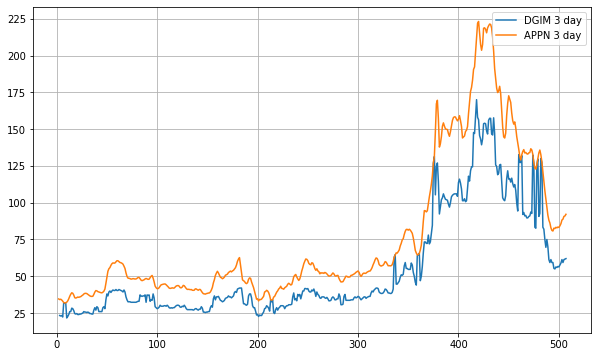

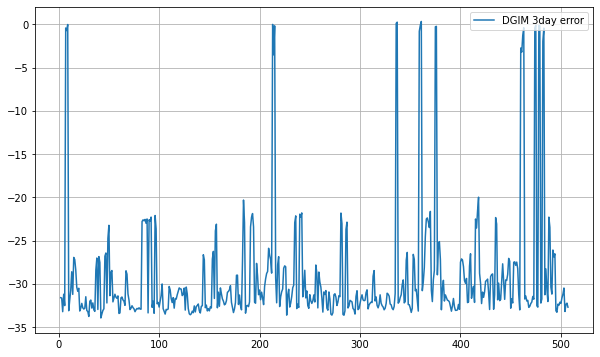

In [14]:
dgim_3day = DGIMMovingAverage(3, appn_3day_list, False)
appn['3-day-dgim'] = dgim_3day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_3day.mov_avg)), dgim_3day.mov_avg, label = "DGIM 3 day")
plt.plot(range(len(dgim_3day.mov_avg)), appn_3day_list, label = "APPN 3 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_3day.error)), dgim_3day.error, label = "DGIM 3day error")
plt.legend(loc=1)

0 nan 4.0 nan
1 nan 7.666666666666667 nan
2 nan 7.888888888888889 nan
3 nan 11.777777777777779 nan
4 nan 15.333333333333334 nan
5 nan 18.88888888888889 nan
6 nan 18.88888888888889 nan
7 nan 22.333333333333332 nan
8 33.46777809990777 25.88888888888889 -22.64533124486016
9 33.075555589463974 25.555555555555557 -22.735823782515293
10 32.98666678534614 25.444444444444443 -22.864457297189606
11 33.02222230699327 25.555555555555557 -22.61103653783005
12 33.252222273084854 25.77777777777778 -22.478029991267892
13 33.64555528428819 25.77777777777778 -23.38429976866665
14 34.31777784559462 26.444444444444443 -22.94243361727711
15 35.1488889058431 27.333333333333332 -22.235569361654907
16 35.752222273084854 28.0 -21.683189967525223
17 36.097777472602 28.333333333333332 -21.50947975997091
18 36.29000006781684 28.444444444444443 -21.619056513394977
19 36.687778049045136 28.88888888888889 -21.257458409529455
20 36.842222425672745 29.0 -21.285964606217817
21 36.701111263699005 28.88888888888889 -21.

194 46.476666344536675 36.77777777777778 -20.86829656597993
195 46.03777737087674 36.333333333333336 -21.07930615191337
196 45.52555508083768 35.77777777777778 -21.411660518474097
197 44.53999922010634 35.44444444444444 -20.421093253086458
198 43.40777715047201 34.55555555555556 -20.393169556299643
199 41.786666022406685 33.333333333333336 -20.22973712365695
200 40.127777099609375 31.22222222222222 -22.192993285625693
201 38.19222174750434 29.333333333333332 -23.195530421714444
202 36.999999576144745 28.555555555555557 -22.822821938715993
203 36.118888431125214 28.555555555555557 -20.94010420611949
204 34.96444405449761 27.444444444444443 -21.507562363445736
205 34.69666629367404 26.77777777777778 -22.82319704397667
206 35.03777737087674 27.11111111111111 -22.623199456579233
207 35.69666629367404 27.77777777777778 -22.183832100028916
208 36.44222174750434 28.555555555555557 -21.641562489226892
209 36.984444088406036 29.11111111111111 -21.288228527850375
210 37.949999491373696 29.111111

477 129.90333302815756 101.77777777777777 -21.651142118334526
478 129.87666744656033 101.55555555555556 -21.80615844848184
479 129.73777855767145 101.33333333333333 -21.893734839703367
480 129.8188908894857 101.33333333333333 -21.942536529912278
481 129.5822253757053 101.0 -22.057211390555445
482 128.66778140597873 100.11111111111111 -22.19411105315032
483 128.14667002360025 99.55555555555556 -22.3112426275136
484 127.61000315348308 99.0 -22.419874967852138
485 125.60889180501302 97.0 -22.77616766926308
486 123.22111341688368 94.55555555555556 -23.263511476597635
487 119.82889048258464 91.0 -24.05838055120313
488 114.47444491916232 92.77777777777777 -18.95328442667352
489 109.12444390190973 87.44444444444444 -19.867225602499385
490 103.93666500515408 82.55555555555556 -20.571286800993917
491 99.01110924614801 78.11111111111111 -21.108740518276743
492 94.1566645304362 72.77777777777777 -22.705654304213052
493 90.57555389404297 69.22222222222223 -23.575159912132893
494 87.82222069634332 

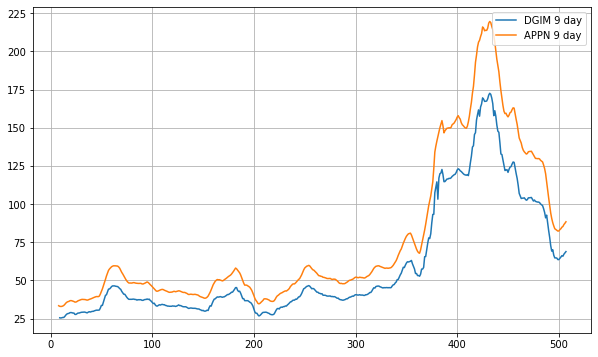

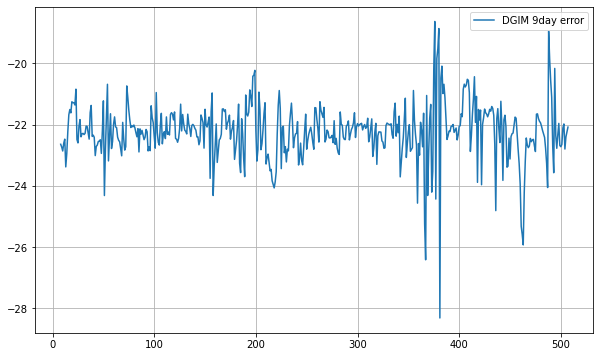

In [15]:
dgim_9day = DGIMMovingAverage(9, appn_9day_list, False)
appn['9-day-dgim'] = dgim_9day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_9day.mov_avg)), dgim_9day.mov_avg, label = "DGIM 9 day")
plt.plot(range(len(dgim_9day.mov_avg)), appn_9day_list, label = "APPN 9 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_9day.error)), dgim_9day.error, label = "DGIM 9day error")
plt.legend(loc=1)

0 nan 1.7142857142857142 nan
1 nan 3.2857142857142856 nan
2 nan 3.380952380952381 nan
3 nan 5.0476190476190474 nan
4 nan 6.571428571428571 nan
5 nan 8.095238095238095 nan
6 nan 8.095238095238095 nan
7 nan 9.571428571428571 nan
8 nan 11.095238095238095 nan
9 nan 12.666666666666666 nan
10 nan 14.19047619047619 nan
11 nan 15.857142857142858 nan
12 nan 17.38095238095238 nan
13 nan 19.19047619047619 nan
14 nan 20.952380952380953 nan
15 nan 19.80952380952381 nan
16 nan 21.571428571428573 nan
17 nan 23.238095238095237 nan
18 nan 24.857142857142858 nan
19 nan 26.38095238095238 nan
20 34.88428588140579 28.095238095238095 -19.461621800853397
21 34.855714343843005 28.095238095238095 -19.39560377938172
22 34.96190479823521 28.238095238095237 -19.231817027541858
23 35.072857084728426 28.38095238095238 -19.080010184542008
24 35.14999989100865 28.428571428571427 -19.122129397663407
25 35.29428554716564 28.666666666666668 -18.77816416383364
26 35.54428554716564 28.80952380952381 -18.947523164321623
27

161 43.0490475609189 35.142857142857146 -18.365540856330604
162 43.45714278448196 34.80952380952381 -19.899188996028784
163 43.782618931361604 35.142857142857146 -19.733314268041134
164 44.193571363176616 35.57142857142857 -19.50994799875411
165 44.651190439860024 36.04761904761905 -19.268403165709515
166 45.18690472557431 36.57142857142857 -19.066311814160755
167 45.80785715012323 37.19047619047619 -18.812015003028495
168 46.46642848423549 37.857142857142854 -18.52796934891065
169 47.07738095238095 38.476190476190474 -18.27032494626375
170 47.69595246087937 37.57142857142857 -21.227218174865094
171 48.48976189749582 38.38095238095238 -20.84730697979668
172 49.14023808070591 39.04761904761905 -20.538400763364553
173 49.817380995977494 39.714285714285715 -20.280261787562765
174 50.43880953107561 40.714285714285715 -19.27984404706968
175 50.99404761904762 41.285714285714285 -19.038169721022534
176 51.4721429007394 41.76190476190476 -18.865035709821115
177 51.78023819696335 42.09523809523

312 52.10833340599423 42.333333333333336 -18.758995795356675
313 52.436428615025115 42.666666666666664 -18.63163111295308
314 52.718333471389045 42.95238095238095 -18.52477473383754
315 53.121666681198846 43.0 -19.053744570821554
316 53.61547633579799 43.095238095238095 -19.621644643555545
317 54.10214287894113 43.57142857142857 -19.464505003204902
318 54.61500004359654 44.095238095238095 -19.261671591982097
319 54.956428709484285 44.04761904761905 -19.84992460032726
320 55.17404774257115 44.61904761904762 -19.130371171552653
321 55.24785723005022 44.714285714285715 -19.066027252248116
322 55.61571430024647 45.095238095238095 -18.916373433977004
323 56.033809661865234 45.476190476190474 -18.841515951502274
324 56.293333507719495 45.714285714285715 -18.792718665315988
325 56.56047621227446 46.0 -18.671123228595942
326 56.98857134864444 46.42857142857143 -18.530030969664228
327 57.406190418061755 46.095238095238095 -19.70336690250898
328 57.6528570992606 46.333333333333336 -19.6339337466

468 146.7952379499163 117.14285714285714 -20.199824749884584
469 144.6895236060733 115.04761904761905 -20.48655895720292
470 142.9671427408854 114.85714285714286 -19.661860302187964
471 141.27666655040923 113.19047619047619 -19.880275381435016
472 139.86761910574776 111.80952380952381 -20.06046537119536
473 138.3471425374349 110.28571428571429 -20.28334502400551
474 137.27285730271112 106.19047619047619 -22.64277273961941
475 135.78047616141183 104.66666666666667 -22.914788911005125
476 134.07571447463263 102.95238095238095 -23.213252037631523
477 132.68809545607795 101.57142857142857 -23.45098614739672
478 132.19190506708054 101.04761904761905 -23.559904067996733
479 131.93380991617838 100.76190476190476 -23.626927149362313
480 131.6809528895787 100.47619047619048 -23.69724833291191
481 132.10047694614954 100.85714285714286 -23.651189466744285
482 132.0838103521438 100.85714285714286 -23.641555624227266
483 131.5233343215216 100.28571428571429 -23.75062964830552
484 130.48619115920295

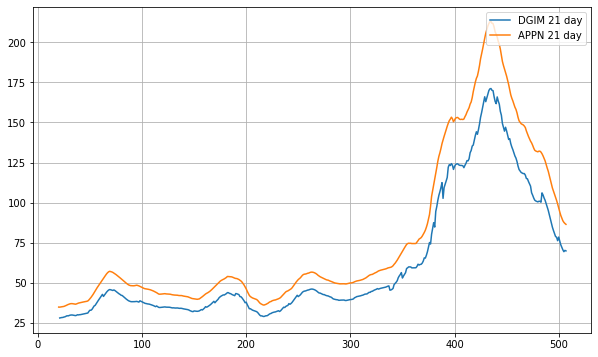

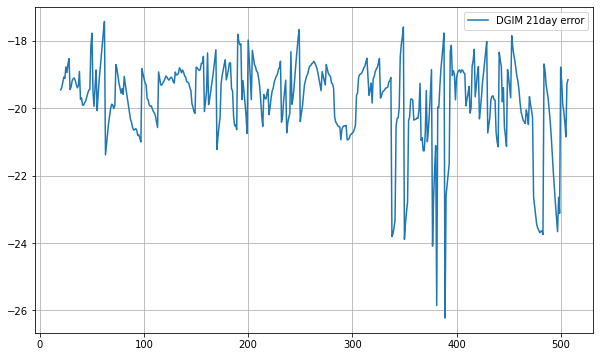

In [16]:
dgim_21day = DGIMMovingAverage(21, appn_21day_list, False)
appn['21-day-dgim'] = dgim_21day.mov_avg
appn.tail()

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.mov_avg, label = "DGIM 21 day")
plt.plot(range(len(dgim_21day.mov_avg)), appn_21day_list, label = "APPN 21 day")
plt.legend(loc=1)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(range(len(dgim_21day.mov_avg)), dgim_21day.error, label = "DGIM 21day error")
plt.legend(loc=1)


In [17]:
appn.tail()

,High,Low,Open,Close,Volume,3-day,9-day,21-day,Change,position-9-21,system-9-21,position-3-9,system-3-9,3-day-dgim,9-day-dgim,21-day-dgim
Date,,,,,,,,,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,88.220001,84.880000,90.346190,0.023709,-1,0.000000,1,0.023709,61.333333,66.222222,72.190476
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,88.806669,85.348889,88.746190,-0.032576,-1,0.000000,1,-0.032576,59.333333,65.888889,70.619048
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,90.676669,86.631111,87.721428,0.070423,-1,0.000000,1,0.070423,61.333333,67.222222,69.428571
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,90.986669,87.454445,87.013333,-0.027621,1,-0.027621,1,-0.027621,61.666667,68.000000,70.238095
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,92.113335,88.414445,86.472857,-0.004935,1,-0.004935,1,-0.004935,62.000000,68.888889,69.904762


## 9/21 DGIM Comparison

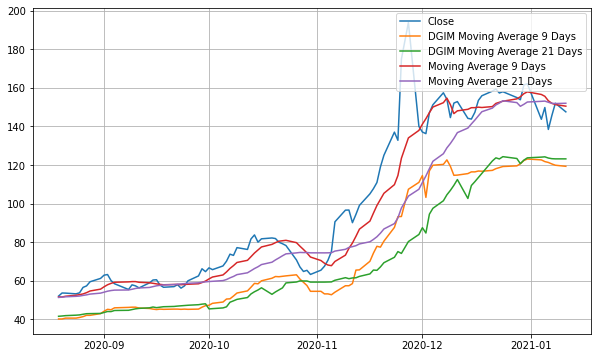

In [18]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['9-day-dgim'][-200:-100],label='DGIM Moving Average 9 Days')
plt.plot(appn['21-day-dgim'][-200:-100],label='DGIM Moving Average 21 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.plot(appn['21-day'][-200:-100],label='Moving Average 21 Days')
plt.legend(loc=1)

<AxesSubplot:xlabel='Date'>

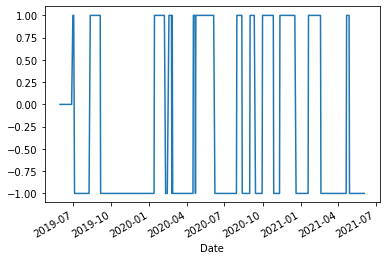

In [19]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-9-21'] = np.where(appn['9-day-dgim'] > appn['21-day-dgim'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-9-21'] = np.where(appn['9-day-dgim'] < appn['21-day-dgim'],-1,appn['position-dgim-9-21'])
appn['position-dgim-9-21'].plot()

,Change,system-dgim-9-21
Date,,
2021-05-28,0.918005,0.805045
2021-06-01,0.885429,0.805045
2021-06-02,0.955852,0.805045
2021-06-03,0.928231,0.805045
2021-06-04,0.923296,0.805045


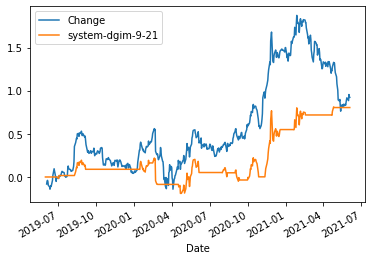

In [20]:
# Whether we are making money with this system
appn['system-dgim-9-21'] = np.where(appn['position-dgim-9-21'] > 0, appn['position-dgim-9-21']* appn['Change'],0)
appn[['Change','system-dgim-9-21']].cumsum().plot()
appn[['Change','system-dgim-9-21']].cumsum().tail()

,system-9-21,system-dgim-9-21
Date,,
2021-05-28,1.289346,0.805045
2021-06-01,1.289346,0.805045
2021-06-02,1.289346,0.805045
2021-06-03,1.261725,0.805045
2021-06-04,1.256790,0.805045


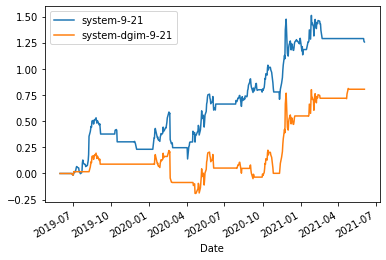

In [21]:
appn[['system-9-21','system-dgim-9-21']].cumsum().plot()
appn[['system-9-21','system-dgim-9-21']].cumsum().tail()

In [22]:
appn.tail()

,High,Low,Open,Close,Volume,3-day,9-day,21-day,Change,position-9-21,system-9-21,position-3-9,system-3-9,3-day-dgim,9-day-dgim,21-day-dgim,position-dgim-9-21,system-dgim-9-21
Date,,,,,,,,,,,,,,,,,,
2021-05-28,97.760002,89.169998,89.250000,90.480003,1281400,88.220001,84.880000,90.346190,0.023709,-1,0.000000,1,0.023709,61.333333,66.222222,72.190476,-1,0.0
2021-06-01,92.139999,84.900002,90.220001,87.580002,982000,88.806669,85.348889,88.746190,-0.032576,-1,0.000000,1,-0.032576,59.333333,65.888889,70.619048,-1,0.0
2021-06-02,94.084999,86.919998,86.919998,93.970001,834300,90.676669,86.631111,87.721428,0.070423,-1,0.000000,1,0.070423,61.333333,67.222222,69.428571,-1,0.0
2021-06-03,94.540001,89.040001,92.860001,91.410004,1166500,90.986669,87.454445,87.013333,-0.027621,1,-0.027621,1,-0.027621,61.666667,68.000000,70.238095,-1,0.0
2021-06-04,93.989998,90.180000,92.449997,90.959999,570700,92.113335,88.414445,86.472857,-0.004935,1,-0.004935,1,-0.004935,62.000000,68.888889,69.904762,-1,0.0


## 3/9 DGIM comparison

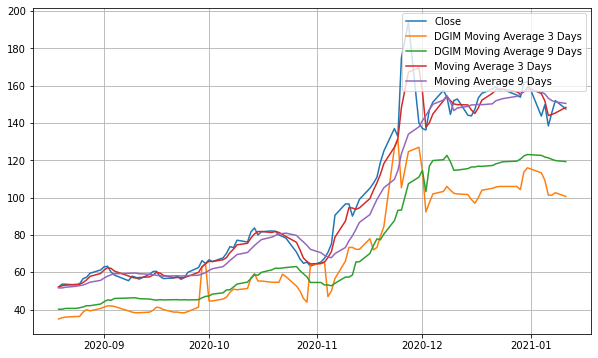

In [23]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(appn['Close'][-200:-100],label='Close')
plt.plot(appn['3-day-dgim'][-200:-100],label='DGIM Moving Average 3 Days')
plt.plot(appn['9-day-dgim'][-200:-100],label='DGIM Moving Average 9 Days')
plt.plot(appn['3-day'][-200:-100],label='Moving Average 3 Days')
plt.plot(appn['9-day'][-200:-100],label='Moving Average 9 Days')
plt.legend(loc=1)

<AxesSubplot:xlabel='Date'>

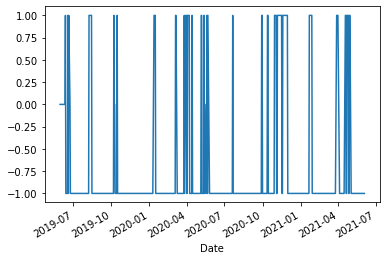

In [24]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-3-9'] = np.where(appn['3-day-dgim'] > appn['9-day-dgim'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-3-9'] = np.where(appn['3-day-dgim'] < appn['9-day-dgim'],-1,appn['position-dgim-3-9'])
appn['position-dgim-3-9'].plot()

,Change,system-dgim-3-9
Date,,
2021-05-28,0.918005,1.293011
2021-06-01,0.885429,1.293011
2021-06-02,0.955852,1.293011
2021-06-03,0.928231,1.293011
2021-06-04,0.923296,1.293011


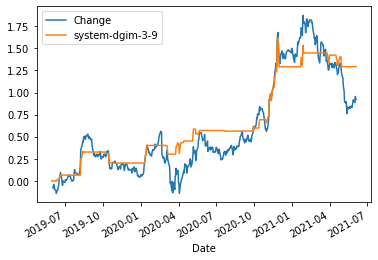

In [25]:
# Whether we are making money with this system
appn['system-dgim-3-9'] = np.where(appn['position-dgim-3-9'] > 0, appn['position-dgim-3-9']* appn['Change'],0)
appn[['Change','system-dgim-3-9']].cumsum().plot()
appn[['Change','system-dgim-3-9']].cumsum().tail()

,system-3-9,system-dgim-3-9
Date,,
2021-05-28,2.065431,1.293011
2021-06-01,2.032855,1.293011
2021-06-02,2.103277,1.293011
2021-06-03,2.075657,1.293011
2021-06-04,2.070722,1.293011


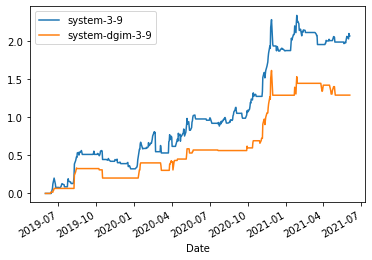

In [26]:
appn[['system-3-9','system-dgim-3-9']].cumsum().plot()
appn[['system-3-9','system-dgim-3-9']].cumsum().tail()

## Pandas 9/21 vs DGIM 3/9

,system-9-21,system-dgim-3-9
Date,,
2021-05-28,1.289346,1.293011
2021-06-01,1.289346,1.293011
2021-06-02,1.289346,1.293011
2021-06-03,1.261725,1.293011
2021-06-04,1.256790,1.293011


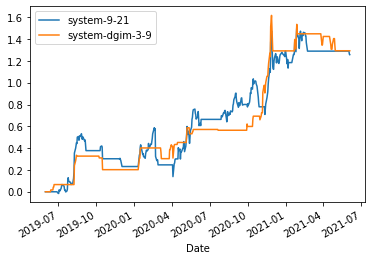

In [27]:
appn[['system-9-21','system-dgim-3-9']].cumsum().plot()
appn[['system-9-21','system-dgim-3-9']].cumsum().tail()

## Normalizing DGIM

<AxesSubplot:xlabel='Date'>

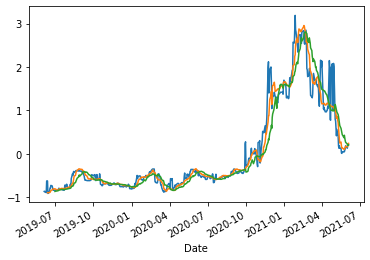

In [28]:
from sklearn import preprocessing

df3 = appn['3-day-dgim']
df9 = appn['9-day-dgim']
df21 = appn['21-day-dgim']

appn['3-day-dgim-norm']=(df3-df3.mean())/df3.std()
appn['9-day-dgim-norm']=(df9-df9.mean())/df9.std()
appn['21-day-dgim-norm']=(df21-df21.mean())/df21.std()

# normalized_df.plot()
appn['3-day-dgim-norm'].plot()
appn['9-day-dgim-norm'].plot()
appn['21-day-dgim-norm'].plot()

<AxesSubplot:xlabel='Date'>

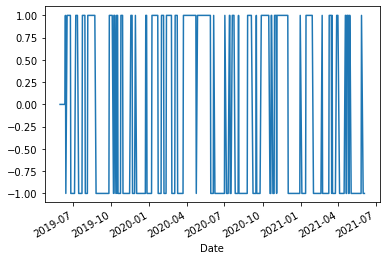

In [29]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-3-9-norm'] = np.where(appn['3-day-dgim-norm'] > appn['9-day-dgim-norm'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-3-9-norm'] = np.where(appn['3-day-dgim-norm'] < appn['9-day-dgim-norm'],-1,appn['position-dgim-3-9-norm'])
appn['position-dgim-3-9-norm'].plot()

,Change,system-dgim-3-9-norm
Date,,
2021-05-28,0.918005,2.090043
2021-06-01,0.885429,2.090043
2021-06-02,0.955852,2.090043
2021-06-03,0.928231,2.090043
2021-06-04,0.923296,2.090043


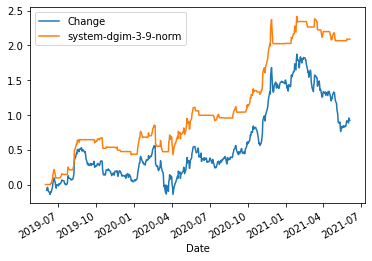

In [30]:
# Whether we are making money with this system
appn['system-dgim-3-9-norm'] = np.where(appn['position-dgim-3-9-norm'] > 0, appn['position-dgim-3-9-norm']* appn['Change'],0)
appn[['Change','system-dgim-3-9-norm']].cumsum().plot()
appn[['Change','system-dgim-3-9-norm']].cumsum().tail()

,system-dgim-3-9-norm,system-dgim-3-9
Date,,
2021-05-28,2.090043,1.293011
2021-06-01,2.090043,1.293011
2021-06-02,2.090043,1.293011
2021-06-03,2.090043,1.293011
2021-06-04,2.090043,1.293011


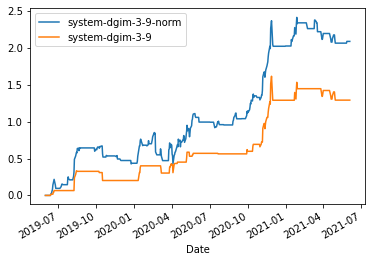

In [31]:
appn[['system-dgim-3-9-norm','system-dgim-3-9']].cumsum().plot()
appn[['system-dgim-3-9-norm','system-dgim-3-9']].cumsum().tail()

,system-dgim-3-9-norm,system-3-9
Date,,
2021-05-28,2.090043,2.065431
2021-06-01,2.090043,2.032855
2021-06-02,2.090043,2.103277
2021-06-03,2.090043,2.075657
2021-06-04,2.090043,2.070722


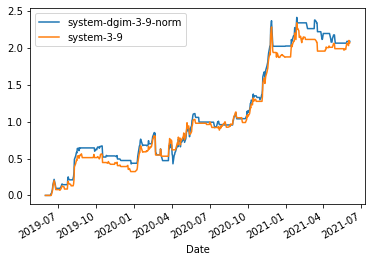

In [32]:
appn[['system-dgim-3-9-norm','system-3-9']].cumsum().plot()
appn[['system-dgim-3-9-norm','system-3-9']].cumsum().tail()

<AxesSubplot:xlabel='Date'>

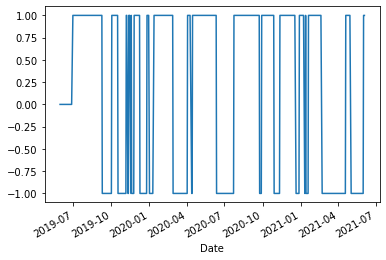

In [33]:
# When the faster moving average is moving above the slower one, indicates time to buy
appn['position-dgim-9-21-norm'] = np.where(appn['9-day-dgim-norm'] > appn['21-day-dgim-norm'], 1,0)
# When the faster moving average is moving below the slower one, indicates time to sell
appn['position-dgim-9-21-norm'] = np.where(appn['9-day-dgim-norm'] < appn['21-day-dgim-norm'],-1,appn['position-dgim-9-21-norm'])
appn['position-dgim-9-21-norm'].plot()

,Change,system-dgim-9-21-norm
Date,,
2021-05-28,0.918005,1.299395
2021-06-01,0.885429,1.299395
2021-06-02,0.955852,1.369818
2021-06-03,0.928231,1.342198
2021-06-04,0.923296,1.337263


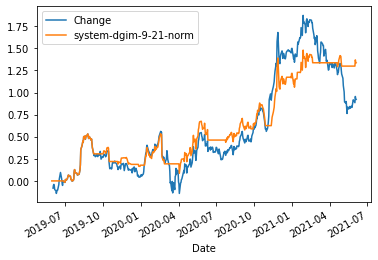

In [34]:
# Whether we are making money with this system
appn['system-dgim-9-21-norm'] = np.where(appn['position-dgim-9-21-norm'] > 0, appn['position-dgim-9-21-norm']* appn['Change'],0)
appn[['Change','system-dgim-9-21-norm']].cumsum().plot()
appn[['Change','system-dgim-9-21-norm']].cumsum().tail()

,system-dgim-9-21-norm,system-dgim-9-21
Date,,
2021-05-28,1.299395,0.805045
2021-06-01,1.299395,0.805045
2021-06-02,1.369818,0.805045
2021-06-03,1.342198,0.805045
2021-06-04,1.337263,0.805045


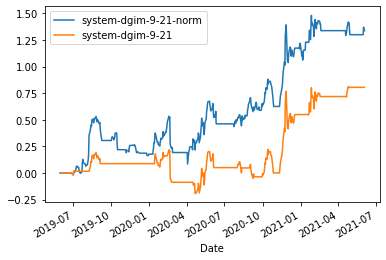

In [35]:
appn[['system-dgim-9-21-norm','system-dgim-9-21']].cumsum().plot()
appn[['system-dgim-9-21-norm','system-dgim-9-21']].cumsum().tail()

,system-dgim-9-21-norm,system-9-21
Date,,
2021-05-28,1.299395,1.289346
2021-06-01,1.299395,1.289346
2021-06-02,1.369818,1.289346
2021-06-03,1.342198,1.261725
2021-06-04,1.337263,1.256790


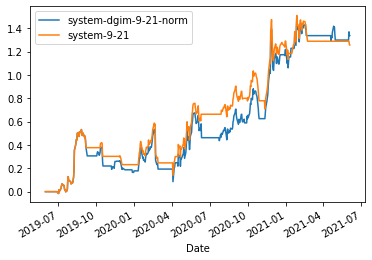

In [36]:
appn[['system-dgim-9-21-norm','system-9-21']].cumsum().plot()
appn[['system-dgim-9-21-norm','system-9-21']].cumsum().tail()

,system-dgim-3-9-norm,system-dgim-9-21-norm
Date,,
2021-05-28,2.090043,1.299395
2021-06-01,2.090043,1.299395
2021-06-02,2.090043,1.369818
2021-06-03,2.090043,1.342198
2021-06-04,2.090043,1.337263


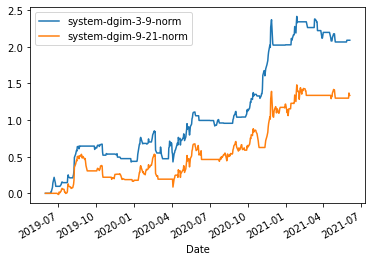

In [37]:
appn[['system-dgim-3-9-norm','system-dgim-9-21-norm']].cumsum().plot()
appn[['system-dgim-3-9-norm','system-dgim-9-21-norm']].cumsum().tail()